## Network Intrusion Detection

In [1]:
import pandas as pd
import numpy as np

In [2]:
data=pd.read_csv('Network.csv')
data.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,class
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal
1,0,udp,other,SF,146,0,0,0,0,0,...,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal
2,0,tcp,private,S0,0,0,0,0,0,0,...,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,anomaly
3,0,tcp,http,SF,232,8153,0,0,0,0,...,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal
4,0,tcp,http,SF,199,420,0,0,0,0,...,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal


In [3]:
data.shape

(25192, 42)

In [4]:
import findspark
findspark.init()

In [5]:
from pyspark import SparkContext,SparkConf
from pyspark.sql import SparkSession

In [6]:
conf = SparkConf().setAppName("Example")
sc = SparkContext(conf=conf)

24/01/06 18:54:01 WARN Utils: Your hostname, Ravis-MacBook-Pro.local resolves to a loopback address: 127.0.0.1; using 192.168.29.245 instead (on interface en0)
24/01/06 18:54:01 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/01/06 18:54:02 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
24/01/06 18:54:02 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [7]:
spark = SparkSession.builder.appName("StringIndexerExample").getOrCreate()


In [8]:
column_names = data.columns.tolist()
column_names

['duration',
 'protocol_type',
 'service',
 'flag',
 'src_bytes',
 'dst_bytes',
 'land',
 'wrong_fragment',
 'urgent',
 'hot',
 'num_failed_logins',
 'logged_in',
 'num_compromised',
 'root_shell',
 'su_attempted',
 'num_root',
 'num_file_creations',
 'num_shells',
 'num_access_files',
 'num_outbound_cmds',
 'is_host_login',
 'is_guest_login',
 'count',
 'srv_count',
 'serror_rate',
 'srv_serror_rate',
 'rerror_rate',
 'srv_rerror_rate',
 'same_srv_rate',
 'diff_srv_rate',
 'srv_diff_host_rate',
 'dst_host_count',
 'dst_host_srv_count',
 'dst_host_same_srv_rate',
 'dst_host_diff_srv_rate',
 'dst_host_same_src_port_rate',
 'dst_host_srv_diff_host_rate',
 'dst_host_serror_rate',
 'dst_host_srv_serror_rate',
 'dst_host_rerror_rate',
 'dst_host_srv_rerror_rate',
 'class']

## STRING INDEXER

In [9]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml import Pipeline


In [10]:
df = spark.createDataFrame(data, column_names)


columns_to_index = ["protocol_type", "service", "flag",'class']

indexers = [StringIndexer(inputCol=col, outputCol=col + "_index", handleInvalid="skip") for col in columns_to_index]

assembler = VectorAssembler(inputCols=[indexer.getOutputCol() for indexer in indexers], outputCol="features")

pipeline = Pipeline(stages=indexers + [assembler])

indexed_data = pipeline.fit(df).transform(df)
indexed_data.select("protocol_type", "service", "flag",'class',"protocol_type_index", "service_index", "flag_index",'class_index', "features").show(truncate=False)



24/01/06 18:54:09 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.
24/01/06 18:54:15 WARN GarbageCollectionMetrics: To enable non-built-in garbage collector(s) List(G1 Concurrent GC), users should configure it(them) to spark.eventLog.gcMetrics.youngGenerationGarbageCollectors or spark.eventLog.gcMetrics.oldGenerationGarbageCollectors


+-------------+----------+----+-------+-------------------+-------------+----------+-----------+------------------+
|protocol_type|service   |flag|class  |protocol_type_index|service_index|flag_index|class_index|features          |
+-------------+----------+----+-------+-------------------+-------------+----------+-----------+------------------+
|tcp          |ftp_data  |SF  |normal |0.0                |4.0          |0.0       |0.0        |(4,[1],[4.0])     |
|udp          |other     |SF  |normal |1.0                |6.0          |0.0       |0.0        |[1.0,6.0,0.0,0.0] |
|tcp          |private   |S0  |anomaly|0.0                |1.0          |1.0       |1.0        |[0.0,1.0,1.0,1.0] |
|tcp          |http      |SF  |normal |0.0                |0.0          |0.0       |0.0        |(4,[],[])         |
|tcp          |http      |SF  |normal |0.0                |0.0          |0.0       |0.0        |(4,[],[])         |
|tcp          |private   |REJ |anomaly|0.0                |1.0          

In [11]:
columns_to_drop = ["protocol_type", "service", "flag",'class','features']

indexed_data  = indexed_data .drop(*columns_to_drop)

indexed_data.show(5)


+--------+---------+---------+----+--------------+------+---+-----------------+---------+---------------+----------+------------+--------+------------------+----------+----------------+-----------------+-------------+--------------+-----+---------+-----------+---------------+-----------+---------------+-------------+-------------+------------------+--------------+------------------+----------------------+----------------------+---------------------------+---------------------------+--------------------+------------------------+--------------------+------------------------+-------------------+-------------+----------+-----------+
|duration|src_bytes|dst_bytes|land|wrong_fragment|urgent|hot|num_failed_logins|logged_in|num_compromised|root_shell|su_attempted|num_root|num_file_creations|num_shells|num_access_files|num_outbound_cmds|is_host_login|is_guest_login|count|srv_count|serror_rate|srv_serror_rate|rerror_rate|srv_rerror_rate|same_srv_rate|diff_srv_rate|srv_diff_host_rate|dst_host_cou

## Label and Data Division 

In [12]:
features = indexed_data.drop(*['class_index']) 
labels = indexed_data['class_index']      

print("Features:")
print(features)

print("\nLabels:")
print(labels)

Features:
DataFrame[duration: bigint, src_bytes: bigint, dst_bytes: bigint, land: bigint, wrong_fragment: bigint, urgent: bigint, hot: bigint, num_failed_logins: bigint, logged_in: bigint, num_compromised: bigint, root_shell: bigint, su_attempted: bigint, num_root: bigint, num_file_creations: bigint, num_shells: bigint, num_access_files: bigint, num_outbound_cmds: bigint, is_host_login: bigint, is_guest_login: bigint, count: bigint, srv_count: bigint, serror_rate: double, srv_serror_rate: double, rerror_rate: double, srv_rerror_rate: double, same_srv_rate: double, diff_srv_rate: double, srv_diff_host_rate: double, dst_host_count: bigint, dst_host_srv_count: bigint, dst_host_same_srv_rate: double, dst_host_diff_srv_rate: double, dst_host_same_src_port_rate: double, dst_host_srv_diff_host_rate: double, dst_host_serror_rate: double, dst_host_srv_serror_rate: double, dst_host_rerror_rate: double, dst_host_srv_rerror_rate: double, protocol_type_index: double, service_index: double, flag_ind

In [13]:
feature_cols=['duration',
 'protocol_type_index',
 'service_index',
 'flag_index',
 'src_bytes',
 'dst_bytes',
 'land',
 'wrong_fragment',
 'urgent',
 'hot',
 'num_failed_logins',
 'logged_in',
 'num_compromised',
 'root_shell',
 'su_attempted',
 'num_root',
 'num_file_creations',
 'num_shells',
 'num_access_files',
 'num_outbound_cmds',
 'is_host_login',
 'is_guest_login',
 'count',
 'srv_count',
 'serror_rate',
 'srv_serror_rate',
 'rerror_rate',
 'srv_rerror_rate',
 'same_srv_rate',
 'diff_srv_rate',
 'srv_diff_host_rate',
 'dst_host_count',
 'dst_host_srv_count',
 'dst_host_same_srv_rate',
 'dst_host_diff_srv_rate',
 'dst_host_same_src_port_rate',
 'dst_host_srv_diff_host_rate',
 'dst_host_serror_rate',
 'dst_host_srv_serror_rate',
 'dst_host_rerror_rate',
 'dst_host_srv_rerror_rate',]

## Vector Assembler

In [14]:
feature_assembler = VectorAssembler(
    inputCols=feature_cols,
    outputCol="features"
)

## PCA

In [15]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import PCA
from pyspark.ml.feature import StandardScaler

In [16]:

# Center and scale features
scaler = StandardScaler(inputCol="features", outputCol="scaled_features", withMean=True, withStd=True)
pipeline = Pipeline(stages=[feature_assembler, scaler])
scaler_model = pipeline.fit(indexed_data)
result = scaler_model.transform(indexed_data)
indexed_data.na.drop()

DataFrame[duration: bigint, src_bytes: bigint, dst_bytes: bigint, land: bigint, wrong_fragment: bigint, urgent: bigint, hot: bigint, num_failed_logins: bigint, logged_in: bigint, num_compromised: bigint, root_shell: bigint, su_attempted: bigint, num_root: bigint, num_file_creations: bigint, num_shells: bigint, num_access_files: bigint, num_outbound_cmds: bigint, is_host_login: bigint, is_guest_login: bigint, count: bigint, srv_count: bigint, serror_rate: double, srv_serror_rate: double, rerror_rate: double, srv_rerror_rate: double, same_srv_rate: double, diff_srv_rate: double, srv_diff_host_rate: double, dst_host_count: bigint, dst_host_srv_count: bigint, dst_host_same_srv_rate: double, dst_host_diff_srv_rate: double, dst_host_same_src_port_rate: double, dst_host_srv_diff_host_rate: double, dst_host_serror_rate: double, dst_host_srv_serror_rate: double, dst_host_rerror_rate: double, dst_host_srv_rerror_rate: double, protocol_type_index: double, service_index: double, flag_index: double

In [17]:
pca = PCA(k=25, inputCol="scaled_features", outputCol="pca_features")
pipeline = Pipeline(stages=[feature_assembler,scaler, pca])
model = pipeline.fit(indexed_data)
result = model.transform(indexed_data)

24/01/06 18:54:21 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
24/01/06 18:54:21 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.VectorBLAS
24/01/06 18:54:21 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.lapack.JNILAPACK


In [18]:
print("DataFrame with PCA Features:")
result.select( "class_index","pca_features").show(truncate=False)

DataFrame with PCA Features:
+-----------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|class_index|pca_features                                                                                                                                                                                                                                                                                                                                                                                                                            

## Decision Tree


In [19]:
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator,MulticlassClassificationEvaluator



In [20]:
(trainingData, testData) = result.randomSplit([0.8, 0.2], seed=123)

tree = DecisionTreeClassifier(featuresCol="pca_features", labelCol="class_index",maxBins=100)

# Create a pipeline
pipeline = Pipeline(stages=[tree])

# Train the model
model_nb = pipeline.fit(trainingData)

# Make predictions on the test data
tree_predictions = model_nb.transform(testData)

# Display predictions
print("Predictions:")
tree_predictions.select( "prediction", "probability").show(truncate=False)



Predictions:
+----------+-----------------------------------------+
|prediction|probability                              |
+----------+-----------------------------------------+
|1.0       |[0.34355828220858897,0.656441717791411]  |
|0.0       |[0.969388743582292,0.03061125641770803]  |
|0.0       |[0.969388743582292,0.03061125641770803]  |
|0.0       |[0.969388743582292,0.03061125641770803]  |
|0.0       |[0.969388743582292,0.03061125641770803]  |
|0.0       |[0.969388743582292,0.03061125641770803]  |
|0.0       |[0.969388743582292,0.03061125641770803]  |
|0.0       |[0.969388743582292,0.03061125641770803]  |
|0.0       |[0.969388743582292,0.03061125641770803]  |
|1.0       |[0.03333333333333333,0.9666666666666667] |
|0.0       |[0.969388743582292,0.03061125641770803]  |
|0.0       |[0.969388743582292,0.03061125641770803]  |
|1.0       |[0.0,1.0]                                |
|1.0       |[0.0,1.0]                                |
|1.0       |[0.03333333333333333,0.9666666666666667]

In [21]:
evaluator = MulticlassClassificationEvaluator(labelCol="class_index", predictionCol="prediction")

In [22]:

accuracy_tree=evaluator.evaluate(tree_predictions,{evaluator.metricName:"accuracy"})
precision_tree = evaluator.evaluate(tree_predictions,{evaluator.metricName:"weightedPrecision"})
recall_tree = evaluator.evaluate(tree_predictions,{evaluator.metricName:"weightedRecall"})
f1_tree = evaluator.evaluate(tree_predictions,{evaluator.metricName:"f1"})
table_tree= [("Accuracy", accuracy_tree*100), ("Precision", precision_tree*100), ("Recall", recall_tree*100), ("F1-Score", f1_tree*100)]
table_df_tree = pd.DataFrame(table_tree, columns=["Metric", "Value"])
table_df_tree

,Metric,Value
0,Accuracy,96.760814
1,Precision,96.772406
2,Recall,96.760814
3,F1-Score,96.757820


## Random FOrest

In [23]:
from pyspark.ml.classification import RandomForestClassifier


In [24]:
rf_classifier = RandomForestClassifier(featuresCol="pca_features", labelCol="class_index",maxBins=100)

# Create a pipeline
pipeline = Pipeline(stages=[rf_classifier])

# Train the model
model_nb = pipeline.fit(trainingData)

# Make predictions on the test data
rf_predictions = model_nb.transform(testData)

# Display predictions
print("Predictions:")
rf_predictions.select( "prediction", "probability").show(truncate=False)

Predictions:
+----------+----------------------------------------+
|prediction|probability                             |
+----------+----------------------------------------+
|0.0       |[0.7645581982204195,0.23544180177958057]|
|0.0       |[0.9089000961714891,0.09109990382851085]|
|0.0       |[0.8704537039407818,0.12954629605921814]|
|0.0       |[0.9243273870996591,0.07567261290034084]|
|0.0       |[0.8907232587530416,0.10927674124695848]|
|0.0       |[0.8931819081196399,0.1068180918803601] |
|0.0       |[0.9243273870996591,0.07567261290034084]|
|0.0       |[0.9243273870996591,0.07567261290034084]|
|0.0       |[0.9243273870996591,0.07567261290034084]|
|1.0       |[0.12482651560415134,0.8751734843958486]|
|0.0       |[0.9132317787687991,0.08676822123120083]|
|0.0       |[0.738473300619086,0.2615266993809141]  |
|1.0       |[0.2392817649849699,0.7607182350150301] |
|1.0       |[0.2392817649849699,0.7607182350150301] |
|0.0       |[0.6575120393850747,0.3424879606149252] |
|0.0       |[0.

In [25]:
evaluator = MulticlassClassificationEvaluator(labelCol="class_index", predictionCol="prediction")

In [26]:
accuracy_rf=evaluator.evaluate(rf_predictions,{evaluator.metricName:"accuracy"})
precision_rf = evaluator.evaluate(rf_predictions,{evaluator.metricName:"weightedPrecision"})
recall_rf = evaluator.evaluate(rf_predictions,{evaluator.metricName:"weightedRecall"})
f1_rf = evaluator.evaluate(rf_predictions,{evaluator.metricName:"f1"})
table_rf= [("Accuracy", accuracy_rf*100), ("Precision", precision_rf*100), ("Recall", recall_rf*100), ("F1-Score", f1_rf*100)]
table_df_rf = pd.DataFrame(table_rf, columns=["Metric", "Value"])
table_df_rf

,Metric,Value
0,Accuracy,96.365791
1,Precision,96.558205
2,Recall,96.365791
3,F1-Score,96.350847


## SVM

In [27]:
from pyspark.ml.classification import LinearSVC


In [28]:

svm = LinearSVC(featuresCol="pca_features", labelCol="class_index")

# Create a pipeline
pipeline = Pipeline(stages=[svm])

# Train the model
model_nb = pipeline.fit(trainingData)

# Make predictions on the test data
svm_predictions = model_nb.transform(testData)

# Display predictions
print("Predictions:")
svm_predictions.select( "class_index","prediction").show(truncate=False)

Predictions:
+-----------+----------+
|class_index|prediction|
+-----------+----------+
|0.0        |1.0       |
|0.0        |0.0       |
|0.0        |0.0       |
|0.0        |0.0       |
|0.0        |0.0       |
|0.0        |0.0       |
|0.0        |0.0       |
|0.0        |0.0       |
|0.0        |0.0       |
|1.0        |0.0       |
|0.0        |0.0       |
|0.0        |0.0       |
|1.0        |1.0       |
|1.0        |1.0       |
|1.0        |0.0       |
|0.0        |0.0       |
|1.0        |1.0       |
|1.0        |1.0       |
|1.0        |1.0       |
|0.0        |1.0       |
+-----------+----------+
only showing top 20 rows



In [29]:
evaluator = MulticlassClassificationEvaluator(labelCol="class_index", predictionCol="prediction")

In [30]:
accuracy_svm=evaluator.evaluate(svm_predictions,{evaluator.metricName:"accuracy"})
precision_svm = evaluator.evaluate(svm_predictions,{evaluator.metricName:"weightedPrecision"})
recall_svm = evaluator.evaluate(svm_predictions,{evaluator.metricName:"weightedRecall"})
f1_svm = evaluator.evaluate(svm_predictions,{evaluator.metricName:"f1"})
table_svm= [("Accuracy", accuracy_svm*100), ("Precision", precision_svm*100), ("Recall", recall_svm*100), ("F1-Score", f1_svm*100)]
table_df_svm = pd.DataFrame(table_svm, columns=["Metric", "Value"])
table_df_svm

,Metric,Value
0,Accuracy,94.212917
1,Precision,94.212245
2,Recall,94.212917
3,F1-Score,94.210265


## MLP

In [31]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import MultilayerPerceptronClassifier
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

In [32]:
layers = [25, 64, 32, 2]
mlp_classifier = MultilayerPerceptronClassifier(layers=layers, seed=1234, labelCol="class_index", featuresCol="pca_features")

# Create a pipeline
pipeline = Pipeline(stages=[ mlp_classifier])
model = pipeline.fit(trainingData)

mlp_predictions = model.transform(testData)


In [33]:
evaluator = MulticlassClassificationEvaluator(labelCol="class_index", predictionCol="prediction")

In [34]:

accuracy_mlp=evaluator.evaluate(mlp_predictions,{evaluator.metricName:"accuracy"})
precision_mlp = evaluator.evaluate(mlp_predictions,{evaluator.metricName:"weightedPrecision"})
recall_mlp = evaluator.evaluate(mlp_predictions,{evaluator.metricName:"weightedRecall"})
f1_mlp= evaluator.evaluate(mlp_predictions,{evaluator.metricName:"f1"})
table_mlp= [("Accuracy", accuracy_mlp*100), ("Precision", precision_mlp*100), ("Recall", recall_mlp*100), ("F1-Score", f1_mlp*100)]
table_df_mlp = pd.DataFrame(table_mlp, columns=["Metric", "Value"])
table_df_mlp

,Metric,Value
0,Accuracy,99.249457
1,Precision,99.249540
2,Recall,99.249457
3,F1-Score,99.249483


## Plots

In [35]:
import matplotlib.pyplot as plt

In [36]:
classifiers = ['SVM','Decision Tree' ,'Random Forest','MLP']

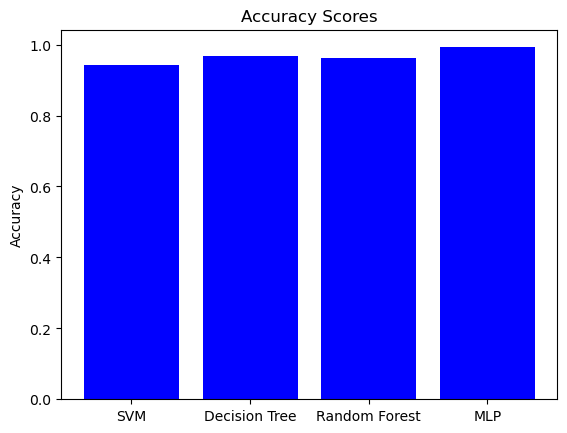

In [37]:
accuracy_scores = [accuracy_svm,accuracy_tree,accuracy_rf,accuracy_mlp]
plt.bar( classifiers,accuracy_scores , color='blue')
plt.title('Accuracy Scores')
plt.ylabel('Accuracy')
plt.show()

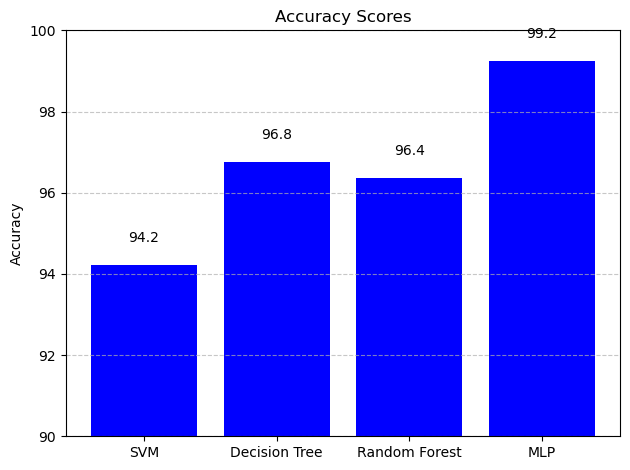

In [44]:
import matplotlib.pyplot as plt

# Sample data
classifiers = [ 'SVM', 'Decision Tree', 'Random Forest', 'MLP']
accuracy_scores = [ accuracy_svm*100, accuracy_tree*100, accuracy_rf*100, accuracy_mlp*100]

# Create a bar plot
plt.bar(classifiers, accuracy_scores, color='blue')
plt.title('Accuracy Scores')
plt.ylabel('Accuracy')

# Set the y-axis range from 60 to 100
plt.ylim(90, 100)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Adding data labels with higher precision on top of each bar
for i, score in enumerate(accuracy_scores):
    plt.text(i, score + 0.5, f'{score:.1f}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()


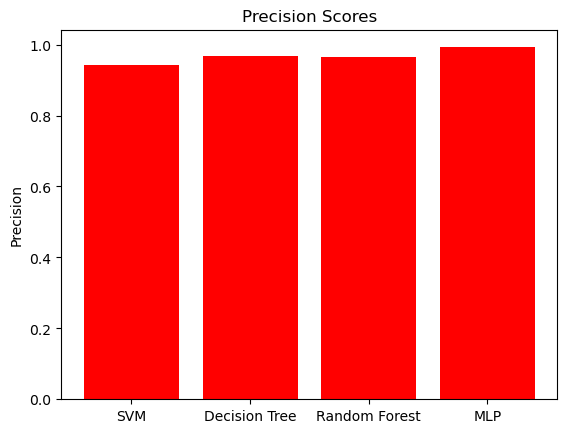

In [39]:
Precision_scores =[precision_svm,precision_tree,precision_rf,precision_mlp]
plt.bar( classifiers,Precision_scores , color='red')
plt.title('Precision Scores')
plt.ylabel('Precision')
plt.show()

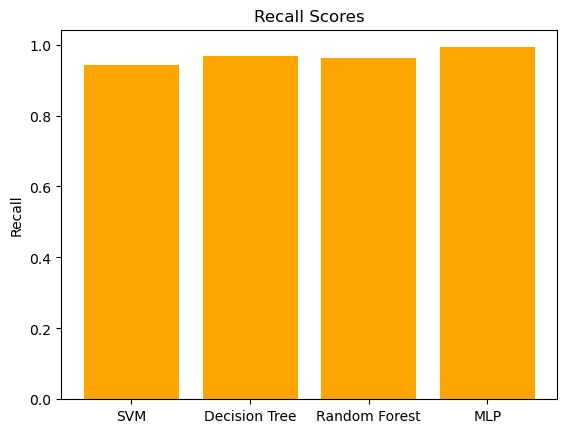

In [40]:
Recall_scores = [recall_svm,recall_tree,recall_rf,precision_mlp]
plt.bar( classifiers,Recall_scores , color='orange')
plt.title('Recall Scores')
plt.ylabel('Recall')
plt.show()

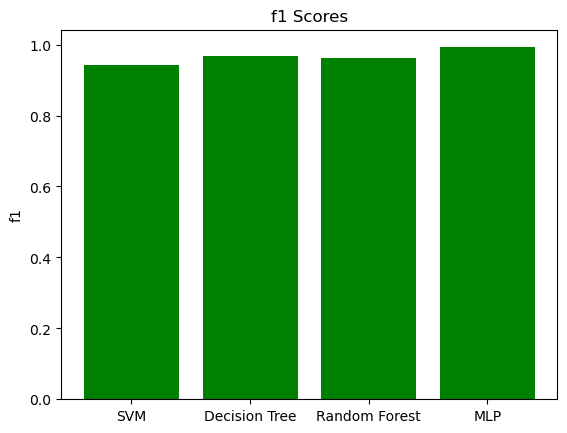

In [41]:
f1_scores = [f1_svm,f1_tree,f1_rf,f1_mlp]
plt.bar( classifiers,f1_scores , color='green')
plt.title('f1 Scores')
plt.ylabel('f1')
plt.show()

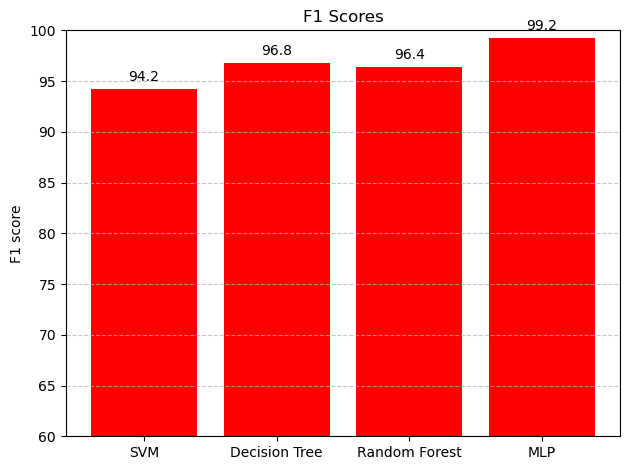

In [45]:
import matplotlib.pyplot as plt

# Sample data
classifiers = [ 'SVM', 'Decision Tree', 'Random Forest', 'MLP']
f1_scores=[f1_svm*100,f1_tree*100,f1_rf*100,f1_mlp*100]
# Create a bar plot
plt.bar(classifiers, f1_scores, color='red')
plt.title('F1 Scores')
plt.ylabel('F1 score')

# Set the y-axis range from 60 to 100
plt.ylim(60, 100)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Adding data labels with higher precision on top of each bar
for i, score in enumerate(f1_scores):
    plt.text(i, score + 0.5, f'{score:.1f}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()


In [43]:
print("Testing Performances for Machine Learning Algorithms-PCA")
result = pd.DataFrame({"Algorithms": ["SVM","Decision Tree" ,"Random Forest","MLP"],
                       "Accuracy":[accuracy_svm,accuracy_tree,accuracy_rf,accuracy_mlp],
                       "Precision":[precision_svm,precision_tree,precision_rf,precision_mlp],
                       "Recall":[recall_svm,recall_tree,recall_rf,recall_mlp],
                       "F1 Score":[f1_svm,f1_tree,f1_rf,f1_mlp]}).set_index('Algorithms')
result*100

Testing Performances for Machine Learning Algorithms-PCA


,Accuracy,Precision,Recall,F1 Score
Algorithms,,,,
SVM,94.212917,94.212245,94.212917,94.210265
Decision Tree,96.760814,96.772406,96.760814,96.757820
Random Forest,96.365791,96.558205,96.365791,96.350847
MLP,99.249457,99.249540,99.249457,99.249483
